<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/updates-w2/tutorials/W2D2_ModernConvnets/W2D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Bonus) Tutorial 2: Facial recognition using modern convnets

**Week 2, Day 2: Modern Convnets**

**By Neuromatch Academy**

__Content creators:__ Laura Pede, Richard Vogg, Marissa Weis, Timo Lüddecke, Alexander Ecker

__Content reviewers:__ Arush Tagade, Polina Turishcheva, Yu-Fang Yang, Bettina Hein, Melvin Selim Atay, Kelson Shilling-Scrivo

__Content editors:__ Roberto Guidotti, Spiros Chavlis

__Production editors:__ Anoop Kulkarni, Roberto Guidotti, Cary Murray, Gagana B, Spiros Chavlis

<br>

*Notebook is based on an initial version by Ben Heil*

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

In this tutorial you will learn about:

1. An application of modern CNNs in facial recognition.
2. Ethical aspects of facial recognition.

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/4r2dp/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for the videos in this tutorial. If you want to download locally the slides, click [here](https://osf.io/4r2dp/download).

---
# Setup

In [2]:
# @title Install dependencies
# @markdown Install `facenet` - A model used to do facial recognition
!pip install facenet-pytorch --quiet
!pip install Pillow --quiet

     |████████████████████████████████| 1.9 MB 33.8 MB/s 


In [3]:
# Imports
import glob
import torch

import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt

from PIL import Image

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from facenet_pytorch import MTCNN, InceptionResnetV1

In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [6]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 1: Face Recognition

*Time estimate: ~12mins*

## Section 1.1: Download and prepare the data

In [7]:
# @title Download Faces Data
import requests, zipfile, io, os

# Original link: https://github.com/ben-heil/cis_522_data.git
url = 'https://osf.io/2kyfb/download'

fname = 'faces'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


In [8]:
# @title Video 1: Face Recognition using CNNs
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV17B4y1K7WV", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"jJqEv8hpRa4", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

One application of large CNNs is **facial recognition**. The problem formulation in facial recognition is a little different from the image classification we've seen so far. In facial recognition, we don't want to have a fixed number of individuals that the model can learn. If that were the case then to learn a new person it would be necessary to modify the output portion of the architecture and retrain to account for the new person.

Instead, we train a model to learn an **embedding** where images from the same individual are close to each other in an embedded space, and images corresponding to different people are far apart. When the model is trained, it takes as input an image and outputs an embedding vector corresponding to the image. 

To achieve this, facial recognitions typically use a **triplet loss** that compares two images from the same individual (i.e., "anchor" and "positive" images) and a negative image from a different individual (i.e., "negative" image). The loss requires the distance between the anchor and negative points to be greater than a margin $\alpha$ + the distance between the anchor and positive points.

## Section 1.2: View and transform the data

A well-trained facial recognition system should be able to map different images of the same individual relatively close together. We will load 15 images of three individuals (maybe you know them - then you can see that your brain is quite well in facial recognition).

After viewing the images, we will transform them: MTCNN ([github repo](https://github.com/ipazc/mtcnn)) detects the face and crops the image around the face. Then we stack all the images together in a tensor.

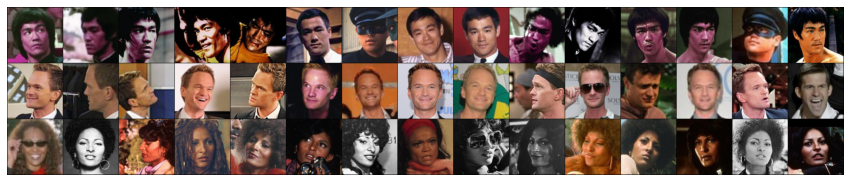

In [9]:
# @title Display Images
# @markdown Here are the source images of Bruce Lee, Neil Patrick Harris, and Pam Grier
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

face_dataset = ImageFolder('faces', transform=train_transform)

image_count = len(face_dataset)

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=45,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = dataiter.next()

# Show images
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(images, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [10]:
# @title Image Preprocessing Function
def process_images(image_dir: str, size=256):
  """
  This function returns two tensors for the
  given image dir: one usable for inputting into the
  facenet model, and one that is [0,1] scaled for
  visualizing

  Parameters:
    image_dir: string
      The glob corresponding to images in a directory
    size: int
      Size [default: 256]

  Returns:
    model_tensor: torch.tensor
      A image_count x channels x height x width
      tensor scaled to between -1 and 1,
      with the faces detected and cropped to the center
      using mtcnn
    display_tensor: torch.tensor
      A transformed version of the model
      tensor scaled to between 0 and 1
  """
  mtcnn = MTCNN(image_size=size, margin=32)
  images = []
  for img_path in glob.glob(image_dir):
    img = Image.open(img_path)
    # Normalize and crop image
    img_cropped = mtcnn(img)
    images.append(img_cropped)

  model_tensor = torch.stack(images)
  display_tensor = model_tensor / (model_tensor.max() * 2)
  display_tensor += .5

  return model_tensor, display_tensor

Now that we have our images loaded, we need to preprocess them. To make the images easier for the network to learn, we crop them to include just faces.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


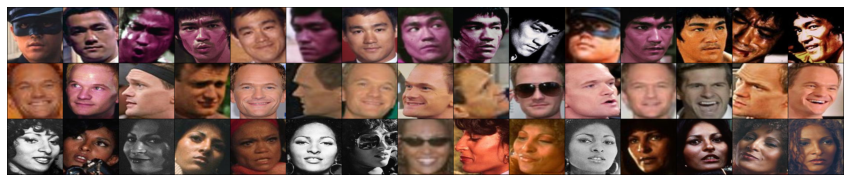

In [11]:
bruce_tensor, bruce_display = process_images('faces/bruce/*.jpg')
neil_tensor, neil_display = process_images('faces/neil/*.jpg')
pam_tensor, pam_display = process_images('faces/pam/*.jpg')

tensor_to_display = torch.cat((bruce_display, neil_display, pam_display))

plt.figure(figsize=(15, 15))
plt.imshow(make_grid(tensor_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

## Section 1.3: Embedding with a pretrained network 

We load a pretrained facial recognition model called [FaceNet](https://github.com/timesler/facenet-pytorch). It was trained on the [VGGFace2](https://github.com/ox-vgg/vgg_face2) dataset which contains 3.31 million images of 9131 individuals.

We use the pretrained model to calculate embeddings for all of our input images.

In [12]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [13]:
# Calculate embedding
resnet.classify = False
bruce_embeddings = resnet(bruce_tensor.to(DEVICE))
neil_embeddings = resnet(neil_tensor.to(DEVICE))
pam_embeddings = resnet(pam_tensor.to(DEVICE))

### Think! 1.3: Embedding vectors

We want to understand what happens when the model receives an image and returns the corresponding embedding vector.

- What are the height, width and number of channels of one input image?
- What are the dimensions of one stack of images (e.g. bruce_tensor)?
- What are the dimensions of the corresponding embedding (e.g. bruce_embeddings)?
- What would be the dimensions of the embedding of one input image?


**Hints:**
- You can double click on a variable name and hover over it to see the dimensions of tensors.
- You do not have to answer the questions in the order they are asked.

In [14]:
# to_remove explanation

"""
1. height: 256, width: 256, channels: 3 (RGB)
2. 15 x 3 x 256 x 256
3. 15 x 512
4. 1 x 512 or just 512
""";

We cannot show 512-dimensional vectors visually, but using **Principal Component Analysis (PCA)** we can project the 512 dimensions onto a 2-dimensional space while preserving the maximum amount of data variation possible. This is just a visual aid for us to understand the concept. Note that if you would like to do any calculation, like distances between two images, this would be done with the whole 512-dimensional embedding vectors.

In [15]:
embedding_tensor = torch.cat((bruce_embeddings,
                              neil_embeddings,
                              pam_embeddings)).to(device='cpu')

pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().cpu().numpy())

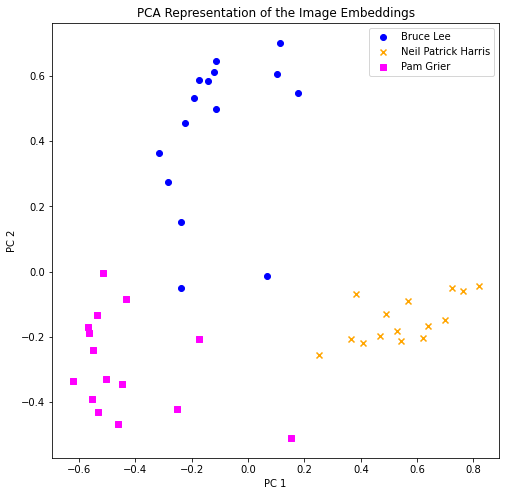

In [16]:
num = 15
categs = 3
colors = ['blue', 'orange', 'magenta']
labels = ['Bruce Lee', 'Neil Patrick Harris', 'Pam Grier']
markers = ['o', 'x', 's']
plt.figure(figsize=(8, 8))
for i in range(categs):
   plt.scatter(pca_tensor[i*num:(i+1)*num, 0],
               pca_tensor[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=labels[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Great! The images corresponding to each individual are separated from each other in the embedding space!

If Neil Patrick Harris wants to unlock his phone with facial recognition, the phone takes the image from the camera, calculates the embedding and checks if it is close to the registered embeddings corresponding to Neil Patrick Harris.

---
# Section 2: Ethics – bias/discrimination due to pre-training datasets

*Time estimate: ~19mins*

Popular facial recognition datasets like VGGFace2 and CASIA-WebFace consist primarily of caucasian faces. 
As a result, even state of the art facial recognition models [substantially underperform](https://openaccess.thecvf.com/content_ICCV_2019/papers/Wang_Racial_Faces_in_the_Wild_Reducing_Racial_Bias_by_Information_ICCV_2019_paper.pdf) when attempting to recognize faces of other races.

Given the implications that poor model performance can have in fields like security and criminal justice, it's very important to be aware of these limitations if you're going to be building facial recognition systems.

In this example we will work with a small subset from the [UTKFace](https://susanqq.github.io/UTKFace/) dataset with 49 pictures of black women and 49 picture of white women. We will use the same pretrained model as in Section 8 of Tutorial 1, see and discuss the consequences of the model being trained on an imbalanced dataset.

In [17]:
# @title Video 2: Ethical aspects
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Jo4y1Q7K3", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"vYilJV3PqUM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 2.1: Download the Data

In [18]:
# @title Run this cell to get the data

# Original link: https://github.com/richardvogg/face_sample.git
url = 'https://osf.io/36wyh/download'
fname = 'face_sample2'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


## Section 2.2: Load, view and transform the data

In [19]:
black_female_tensor, black_female_display = process_images('face_sample2/??_1_1_*.jpg', size=150)
white_female_tensor, white_female_display = process_images('face_sample2/??_1_0_*.jpg', size=150)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


We can check the dimensions of these tensors and see that for each group we have images of size $150 \times 150$ and three channels (RGB) of 49 individuals.

**Note:** Originally, the size of images was $200 \times 200$, but due to RAM resources, we have reduced it. You can change it back, i.e., `size=200`.

In [20]:
print(white_female_tensor.shape)
print(black_female_tensor.shape)

torch.Size([49, 3, 150, 150])
torch.Size([49, 3, 150, 150])


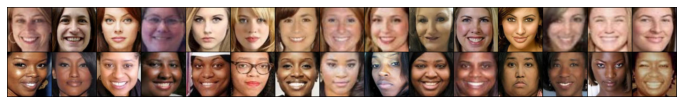

In [21]:
# @title Visualize some example faces
tensor_to_display = torch.cat((white_female_display[:15],
                               black_female_display[:15]))

plt.figure(figsize=(12, 12))
plt.imshow(make_grid(tensor_to_display, nrow = 15).permute(1, 2, 0))
plt.axis('off')
plt.show()

## Section 2.3: Calculate embeddings

We use the same pretrained facial recognition network as in section 8 to calculate embeddings. If you have memory issues running this part, go to `Edit > Notebook settings` and check if GPU is selected as `Hardware accelerator`. If this does not help you can restart the notebook, go to `Runtime -> Restart runtime`.

In [22]:
resnet.classify = False
black_female_embeddings = resnet(black_female_tensor.to(DEVICE))
white_female_embeddings = resnet(white_female_tensor.to(DEVICE))

We will use the embeddings to show that the model was trained on an imbalanced dataset. For this, we are going to calculate a distance matrix of all combinations of images, like in this small example with $n=3$ (in our case $n=98$).

<img height=500 src=https://raw.githubusercontent.com/richardvogg/face_sample/main/04_DistanceMatrix.png>

Calculate the distance between each pair of image embeddings in our tensor and visualize all the distances. Remember that two embeddings are vectors and the distance between two vectors is the Euclidean distance.

In [23]:
# @title Function to calculate pairwise distances

# @markdown [`torch.cdist`](https://pytorch.org/docs/stable/generated/torch.cdist.html) is used

def calculate_pairwise_distances(embedding_tensor):
  """
  This function calculates the distance
  between each pair of image embeddings
  in a tensor using the `torch.cdist`.

  Parameters:
    embedding_tensor : torch.Tensor
      A num_images x embedding_dimension tensor

  Returns:
    distances : torch.Tensor
      A num_images x num_images tensor
      containing the pairwise distances between
      each to image embedding
  """

  distances = torch.cdist(embedding_tensor, embedding_tensor)

  return distances

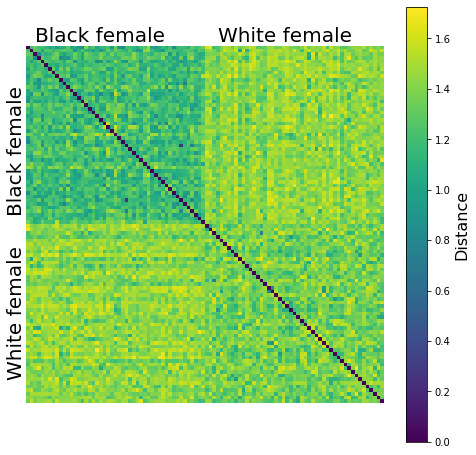

In [24]:
# @title Visualize the distances

embedding_tensor = torch.cat((black_female_embeddings,
                              white_female_embeddings)).to(device='cpu')

distances = calculate_pairwise_distances(embedding_tensor)

plt.figure(figsize=(8, 8))
plt.imshow(distances.detach().cpu().numpy())
plt.annotate('Black female', (2, -0.5), fontsize=20, va='bottom')
plt.annotate('White female', (52, -0.5), fontsize=20, va='bottom')
plt.annotate('Black female', (-0.5, 45), fontsize=20, rotation=90, ha='right')
plt.annotate('White female', (-0.5, 90), fontsize=20, rotation=90, ha='right')
cbar = plt.colorbar()
cbar.set_label('Distance', fontsize=16)
plt.axis('off')
plt.show()

## Exercise 2.1

What do you observe? The faces of which group are more similar to each other for the Face Detection algorithm?

In [25]:
# to_remove explanation

"""
The distances between black female embeddings are generally lower than the distances
between white female embeddings, i.e. for the Face Detection algorithm faces
of black females are more similar to each other.
""";

## Exercise 2.2
- What does it mean in real life applications that the distance is smaller between the embeddings of one group?
- Can you come up with example situations/applications where this has a negative impact?
- What could you do to avoid these problems?

In [26]:
# to_remove explanation

"""
1. Algorithms will have problems to distinguish people of this group
   if the distances of the embeddings are smaller.

2. Many examples possible
  - Unblocking the smartphone with a face recognition system might not work or not be secure.
  - Surveillance cameras might confuse indivduals.
  - Social network automated tagging might confuse individuals.

3. Train the model on a balanced dataset with enough samples for each minority.
   If you use pre-trained models, obtain information about the datasets they were pretrained on.
""";

Lastly, to show the importance of the dataset which you use to pretrain your model, look at how much space white men and women take in different embeddings. *FairFace* is a dataset which is specifically created with completely balanced classes. The blue dots in all visualizations are white male and white female.

<img src=https://i.imgur.com/hCdCBOa.png>

Adopted from [Kärkkäinen and Joo, 2019, arXiv](https://arxiv.org/abs/1908.04913)

---
# Section 3: Within Sum of Squares

*Time estimate: ~10mins*


We can try to put this observation in numbers. For this we work with the embeddings.
We want to calculate the centroid of each group, which is the average of the 49 embeddings of the group. As each embedding vector has a dimension of 512, the centroid will also have this dimension.

Now we can calculate how far away the observations $x$ of each group $S_i$ are from the centroid $\mu_i$. This concept is known as Within Sum of Squares (WSS) from cluster analysis.

\begin{equation}
\text{WSS} = \sum_{x\in S_i} ||x - \mu_i||^2
\end{equation}

where $|| \cdot ||$ is the Euclidean norm.

The Within Sum of Squares (WSS) is a number which measures this variability of a group in the embedding space. If all embeddings of one group were very close to each other, the WSS would be very small. In our case we see that the WSS for the black females is much smaller than for the white females. This means that it is much harder for the model to distinguish two black females than to distinguish two white females. The WSS complements the observation from the distance matrix, where we observed overall smaller pairwise distances between black females.

In [27]:
# @title Function to calculate WSS

def wss(group):
  """
  This function returns the sum of squared distances
  of the N vectors of a
  group tensor (N x K) to its centroid (1 x K).
   Hints:
    - to calculate the centroid, torch.mean()
      will be of use.
    - We need the mean of the N=49 observations.
      If our input tensor is of size
      N x K, we expect the centroid to be of
      dimensions 1 x K.
      Use the axis argument within torch.mean

  Args:
    group: torch.tensor
      A image_count x embedding_size tensor

  Returns:
    sum_sq: torch.tensor
      A 1x1 tensor with the sum of squared distances.
    """

  centroid = torch.mean(group, axis=0)
  distance = torch.linalg.norm(group - centroid.view(1, -1), axis=1)
  sum_sq = torch.sum(distance**2)
  return sum_sq

In [28]:
# @markdown Let's calculate the WSS for the two groups of our example.

print(f"Black female embedding WSS: {np.round(wss(black_female_embeddings).item(), 2)}")
print(f"White female embedding WSS: {np.round(wss(white_female_embeddings).item(), 2)}")

Black female embedding WSS: 34.2
White female embedding WSS: 44.6


---
# Summary

In this tutorial we have learned how to apply a modern convnet in real application such as facial recognition. However, as the state-of-the-art tools for facial recognition are trained mostly with caucasian faces, they fail or they perform much worse when they have to deal with faces from other races.